In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from torch import Tensor
from collections import defaultdict
import numpy as np
import time
from representation_model import PENetwork, CompositeClassifierFromRepresentations
ROOT = "../../"
import sys
sys.path.append(ROOT)
from utils.functions import sigmoid
from models import Filepath, Emulation

dataset_folder = "/data/quo.vadis/evaluation/representations/set_cropped_20/"

X_train = np.load(open(dataset_folder + "Xtrain.npy", "rb"))
X_val = np.load(open(dataset_folder + "Xval.npy", "rb"))
y_train = np.load(open(dataset_folder + "ytrain.npy", "rb"))
y_val = np.load(open(dataset_folder + "yval.npy", "rb"))

LIMIT = X_train.shape[0]

In [20]:
def get_module_probs(model, models):
    if model == "ember":
        logits = models[model].classify_representations(Tensor(X_vals[model])).detach().numpy()
        probs = sigmoid(logits)
    else:
        logits = models[model].model.classify_representations(Tensor(X_vals[model])).detach().numpy()
        probs = sigmoid(logits[:,0])
    return probs

def fit(models, x_trains, y_train, save=False):
    for model in models:
        if model in ["filepaths", "emulation", "ember"]:
            # TODO: no need fitting
            continue
        print(f"Fitting model: {model}", end=" | ")
        c1 = time.time()
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_late_fusion_model()
        print(f"Took: {time.time() - c1:.2f}s")

def evaluate(models, X_vals, y_val, ax=None, threshold=0.6, print_score=True):
    probs = {}
    for model in models:
        print(f"[!] Evaluating model: {model}...")
        if model in ["filepaths", "emulation", "ember"]:
            # TODO: -- .classify_representations() passes 128 > 1 & returns logits, need softmax()
            probs[model] = get_module_probs(model, models)
        else: # late fusion
            probs[model] = models[model].predict_proba(X_vals[model])[:,1]
        
        preds = np.where(probs[model] > threshold, 1, 0)
        
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y_val, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y_val, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y_val.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y_val))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y_val, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    _ = ax.legend()
    return probs

# Building Xs and modules

In [16]:
X_trains = {}
X_vals = {}
models = {}

modulelist = [["ember"], ["filepaths"], ["emulation"], 
            ["filepaths", "emulation"], ["ember", "emulation"], 
            ["ember", "filepaths"], ["ember", "filepaths", "emulation"]]

mm = CompositeClassifierFromRepresentations(root=ROOT)

for combination in [["ember"], ["emulation"], ["filepaths"], ["ember", "emulation"], ["ember", "filepaths", "emulation"]]: #modulelist:
    name = " & ".join(combination)
    if len(combination) == 1:
        if combination[0] == "ember":
            models[name] = PENetwork()
        elif combination[0] == "emulation":
            models[name] = Emulation(mm.apimap, mm.device, 
                                    emulation_report_path=mm.emulation_report_path,
                                    speakeasy_config=mm.speakeasy_config)
        elif combination[0] == "filepaths":
            models[name] = Filepath(mm.bytes, mm.device, filepath_csv_location=mm.fielpath_csvs)
    else:
        models[name] = CompositeClassifierFromRepresentations(root=ROOT, 
                                                meta_model = "MultiLayerPerceptron",
                                                load_meta_model = False,
                                                mlp_hidden_layer_sizes=(128,64,32))
    
    X_trains[name] = mm.get_modular_x(combination, X_train)
    X_vals[name] = mm.get_modular_x(combination, X_val)

In [17]:
fit(models, X_trains, y_train[0:LIMIT])

Fitting model: ember & emulation | Took: 0.04s
Fitting model: ember & filepaths & emulation | Took: 0.03s


[!] Evaluating model: ember...

 ====== ember ======
ROC AUC score: 0.5520833333333334
Classification report:
              precision    recall  f1-score   support

         0.0     0.4667    0.8750    0.6087         8
         1.0     0.8000    0.3333    0.4706        12

    accuracy                         0.5500        20
   macro avg     0.6333    0.6042    0.5396        20
weighted avg     0.6667    0.5500    0.5258        20

[!] Evaluating model: emulation...

 ====== emulation ======
ROC AUC score: 0.8697916666666666
Classification report:
              precision    recall  f1-score   support

         0.0     0.4000    1.0000    0.5714         8
         1.0     0.0000    0.0000    0.0000        12

    accuracy                         0.4000        20
   macro avg     0.2000    0.5000    0.2857        20
weighted avg     0.1600    0.4000    0.2286        20

[!] Evaluating model: filepaths...

 ====== filepaths ======
ROC AUC score: 1.0
Classification report:
              p

/data/quo.vadis/_localQuoVadisPythonEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/quo.vadis/_localQuoVadisPythonEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/quo.vadis/_localQuoVadisPythonEnv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

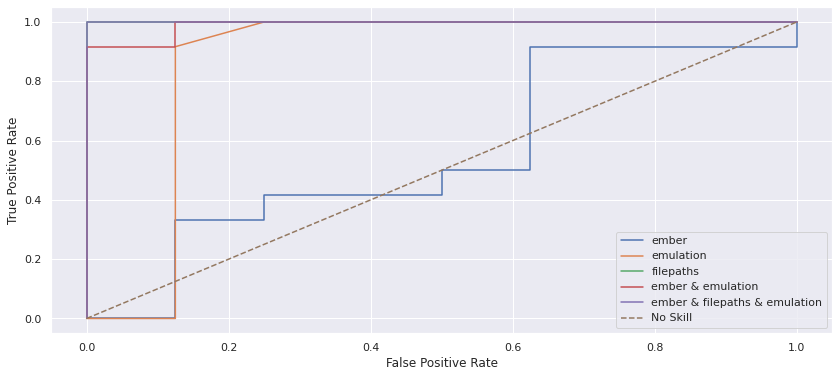

In [21]:
pp = evaluate(models, X_vals, y_val[:LIMIT])
#plt.xlim([-0.005, 0.04])
#plt.ylim([0.9, 1.01])
plt.legend(loc="lower right")

# Variable thresholds

In [24]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    thr_index = np.where(thresholds <= threshold)[0][0]
    return values[thr_index]

probs = {}
for model in models:
    if "&" not in model:
        probs[model] = get_module_probs(model, models)
    else:
        probs[model] = models[model].predict_proba(X_vals[model])[:,1]

fprs = {}
fnrs = {}
tprs = {}
thresholds_roc = {}
thresholds_det = {}

for model in probs:
    fprs[model], tprs[model], thresholds_roc[model] = roc_curve(y_val[:LIMIT], probs[model])
    _, fnrs[model], thresholds_det[model] = det_curve(y_val[:LIMIT], probs[model])

In [29]:
fixed_fpr_rates = defaultdict(list)
for fpr_rate in list(np.arange(0.00025, 0.0031, 0.00025)):
    print("===" * 10)
    for model in models:
        threshold = get_threshold_from_rate(thresholds_roc[model], fprs[model], fpr_rate)
        tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
        fnr_rate = get_value_from_threshold(fnrs[model], thresholds_det[model][::-1], threshold)
        fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
        print(f"FPR: {fpr_rate*100:>5.3f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

FPR: 0.025% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.8088 | ember
FPR: 0.025% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.5157 | emulation
FPR: 0.025% | TPR: 100.00% | FNR:  0.00% | Thr.: 0.2173 | filepaths
FPR: 0.025% | TPR: 91.67% | FNR:  8.33% | Thr.: 0.7316 | ember & emulation
FPR: 0.025% | TPR: 100.00% | FNR:  0.00% | Thr.: 0.0000 | ember & filepaths & emulation
FPR: 0.050% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.8088 | ember
FPR: 0.050% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.5157 | emulation
FPR: 0.050% | TPR: 100.00% | FNR:  0.00% | Thr.: 0.2173 | filepaths
FPR: 0.050% | TPR: 91.67% | FNR:  8.33% | Thr.: 0.7316 | ember & emulation
FPR: 0.050% | TPR: 100.00% | FNR:  0.00% | Thr.: 0.0000 | ember & filepaths & emulation
FPR: 0.075% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.8088 | ember
FPR: 0.075% | TPR:  0.00% | FNR:  0.00% | Thr.: 0.5157 | emulation
FPR: 0.075% | TPR: 100.00% | FNR:  0.00% | Thr.: 0.2173 | filepaths
FPR: 0.075% | TPR: 91.67% | FNR:  8.33% | Thr.: 0.7316 | ember & emulation
FPR: 

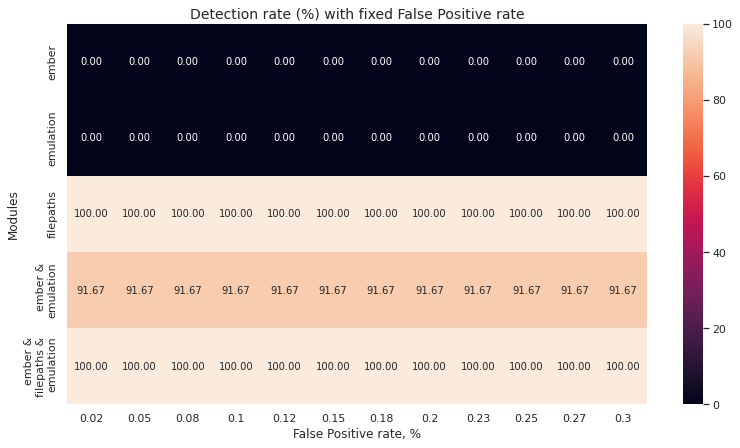

In [30]:
# keys for y label
keys = models.keys()

# rates for x label
fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
fpr_rates = [np.round(x*100, 2) for x in fpr_rates]

# rearrange rows, so "all" is last
tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
tpr_rates = np.round(tpr_rates*100,2)

fig, ax = plt.subplots(figsize=(13,7))
ax = sns.heatmap(tpr_rates, ax = ax,
            annot=True, fmt=".2f",
            xticklabels=fpr_rates,
            yticklabels=[x.replace(" & ", " &\n") for x in keys])

ax.set_xlabel("False Positive rate, %", fontsize=12)
ax.set_ylabel("Modules", fontsize=12)
_ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

#fig.savefig("/data/quo.vadis/img/rate_heatmap.eps",  format='eps', dpi=600, bbox_inches='tight')